[Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I)

In [3]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams['axes.axisbelow'] = True
%matplotlib inline

### Dataset

In [5]:
with open('./data/names.txt', 'r') as f:
    words = f.read().splitlines()

len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [6]:
SEP_TOK = '.'
vocab = [SEP_TOK] + sorted(list(set(''.join(words))) )
stoi  = {s: i for i, s in enumerate(vocab)}
itos  = {i: s for i, s in enumerate(vocab)}
print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [7]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for word in words:
        context = [stoi[SEP_TOK]] * block_size
        for ch in word + SEP_TOK:
            ix = stoi[ch]
            # print(f'{"".join(itos[ch] for ch in context)} ---> {itos[ix]}')
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [8]:
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

random.shuffle(words)
X, Y = build_dataset(words)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([228146, 3]) torch.Size([228146])
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Model

In [24]:
n_embed = 10
hidden_size = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((len(vocab), n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, len(vocab)), generator=g)
b2 = torch.randn(len(vocab), generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters), [p.shape for p in parameters]

(11897,
 [torch.Size([27, 10]),
  torch.Size([30, 200]),
  torch.Size([200]),
  torch.Size([200, 27]),
  torch.Size([27])])

In [25]:
# training setup
batch_size = 32

for p in parameters:
    p.requires_grad = True

In [26]:
losses = []
step_count = 0

In [27]:
num_steps = 200_000
for i in tqdm(range(num_steps), 'Training'):
    # get minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb = Xtr[ix]
    Yb = Ytr[ix]

    # forward pass
    emb = C[Xb].view((Xb.shape[0]), block_size*n_embed)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    # stats
    step_count += 1
    losses.append(loss.log10().item())

print(loss.item())

Training: 100%|██████████| 200000/200000 [02:25<00:00, 1371.38it/s]

2.415053606033325


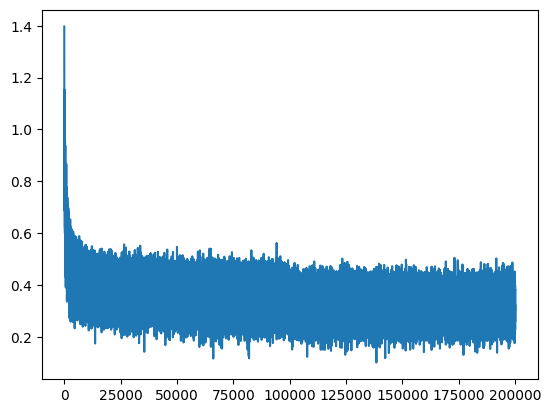

In [28]:
plt.plot(torch.arange(step_count), losses)

In [29]:
# evaluating on the train split
emb = C[Xtr].view((Xtr.shape[0]), block_size*n_embed)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1216, grad_fn=<NllLossBackward0>)

In [30]:
# evaluating on the dev split
emb = C[Xdev].view((Xdev.shape[0]), block_size*n_embed)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1641, grad_fn=<NllLossBackward0>)

### Sampling from the model

In [31]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [stoi[SEP_TOK]]*block_size
    while True:
        emb = C[torch.tensor(context)].view(1, block_size*n_embed)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        if ix == stoi[SEP_TOK]:
            break
        out.append(itos[ix])
        context = context[1:] + [ix]
    print(''.join(out))

junide
janasid
parlay
adin
kai
rito
cassaretz
samela
zamilena
jadbiainroik
las
jaicayla
ter
nomuntsyn
demmerconne
waqhuan
rhose
yar
ocely
jamilyn


### Visualising embeddings

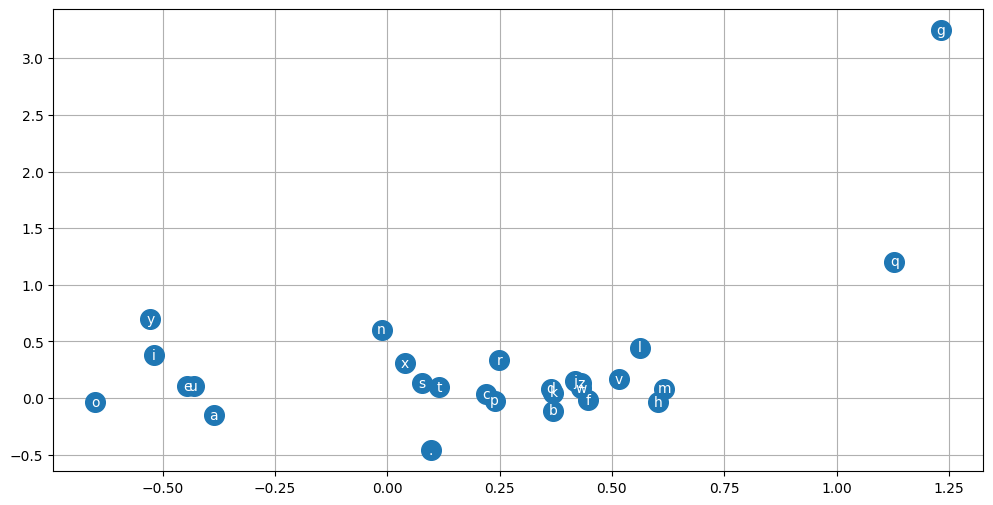

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(C.data[:, 0], C.data[:, 1], s=200)
for i, ch in enumerate(vocab):
    plt.text(C[i, 0].item(), C[i, 1].item(), s=ch, ha='center', va='center', color='white')

plt.grid()

### Searching for good lr

In [ ]:
n_embed = 2
hidden_size = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((len(vocab), n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, len(vocab)), generator=g)
b2 = torch.randn(len(vocab), generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters), [p.shape for p in parameters]

(3481,
 [torch.Size([27, 2]),
  torch.Size([6, 100]),
  torch.Size([100]),
  torch.Size([100, 27]),
  torch.Size([27])])

In [ ]:
for p in parameters:
    p.requires_grad = True

batch_size = 32
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
losses = []
for i in range(1000):
    # get minibatch
    ix = torch.randint(0, X.shape[0], (batch_size,))
    Xb = X[ix]
    Yb = Y[ix]
    # forward pass
    emb = C[Xb].view((Xb.shape[0]), block_size*n_embed)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = lrs[i]
    for p in parameters:
        p.data += -lr*p.grad

    losses.append(loss.item())

In [ ]:
min_losses, ixs = torch.topk(torch.tensor(losses), k=5, largest=False)
min_lrs = [lrs[ix].item() for ix in ixs]
print(min_losses)
print(ixs)
print(min_lrs)

tensor([2.4670, 2.5409, 2.5633, 2.6289, 2.6827])
tensor([698, 692, 749, 837, 753])
[0.12476595491170883, 0.11969555914402008, 0.1775207817554474, 0.3262222111225128, 0.18249930441379547]


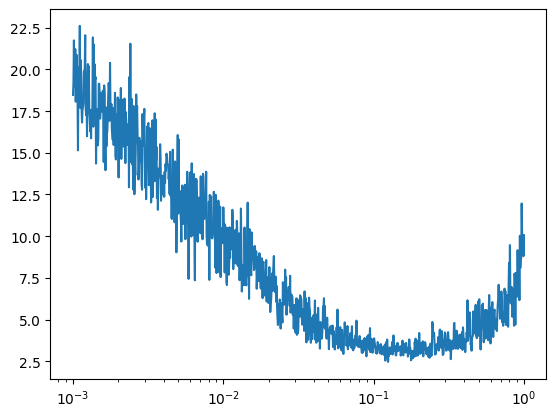

In [ ]:
plt.plot(lrs.tolist(), losses)
plt.xscale('log')

In [ ]:
window_span = 10
smooth_losses = []
for i in range(len(losses)):
    start = max(0, i - window_span)
    end = min(len(losses), i + window_span + 1)
    new_loss = sum(losses[start:end]) / len(losses[start:end])
    smooth_losses.append(new_loss)

In [ ]:
min_losses, ixs = torch.topk(torch.tensor(smooth_losses), k=5, largest=False)
min_lrs = [lrs[ix].item() for ix in ixs]
print(min_losses)
print(ixs)
print(min_lrs)

tensor([3.0971, 3.1110, 3.1137, 3.1249, 3.1259])
tensor([746, 745, 747, 694, 750])
[0.17387622594833374, 0.17267808318138123, 0.17508269846439362, 0.1213623657822609, 0.17875254154205322]


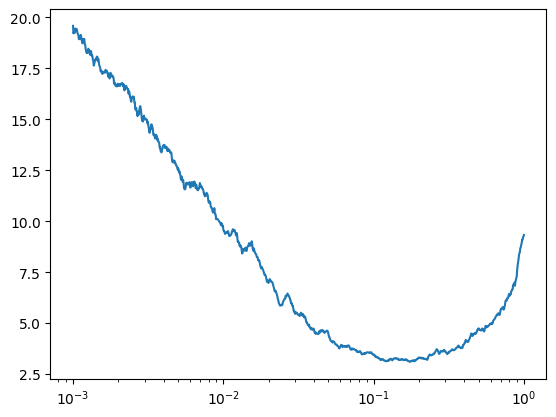

In [ ]:
plt.plot(lrs.tolist(), smooth_losses)
plt.xscale('log')